In [1]:
import torch
import torch.distributions as D
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import sys
import matplotlib.pyplot as plt

from tqdm.auto import trange
from copy import deepcopy
from itertools import cycle
from sklearn.model_selection import train_test_split

from sw import *
from swgf import *
from fid_score import *

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

## With Autoencoder

In [3]:
transform = torchvision.transforms.Compose([
                torchvision.transforms.CenterCrop(178),
                torchvision.transforms.Resize((64,64)),
                torchvision.transforms.ToTensor(),
    ])

dataset = torchvision.datasets.ImageFolder(root="~/celeba", transform=transform)

print(len(dataset))

405198


In [6]:
train_idx, test_idx = train_test_split(list(range(len(dataset))), test_size=0.2)
train_dataset = torch.utils.data.Subset(dataset, train_idx)
test_dataset = torch.utils.data.Subset(dataset, test_idx)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

torch.Size([32, 3, 64, 64]) 9984


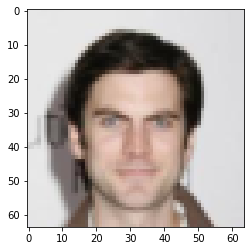

In [7]:
real_cpu = torch.zeros((10000,3,64,64))

cpt = 0
for data, _ in test_loader:
    if cpt+32>10000:
#         real_cpu[cpt:] = inverse_logit(data)
        print(data.size(), cpt)
        real_cpu[cpt:] = data[:10000-cpt]
        break
    else:
#         real_cpu[cpt:cpt+32] = inverse_logit(data)
        real_cpu[cpt:cpt+32] = data
    cpt += 32
    
plt.imshow(np.transpose(real_cpu[-1],(1,2,0)))
plt.show()

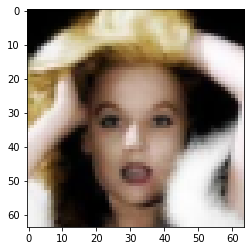

In [8]:
train_cpu = torch.zeros((10000,3,64,64))

cpt = 0
for data, _ in train_loader:
    if cpt+128>10000:
        train_cpu[cpt:] = data[:16]
    else:
        train_cpu[cpt:cpt+128] = data
    cpt += 128
    if cpt>10000:
        break
    
plt.imshow(np.transpose(train_cpu[-1],(1,2,0)))
plt.show()

### With Pretrained AutoEncoder from SWF

In [31]:
def val_ae(rho, autoencoder, device, d=48):
    with torch.no_grad():
        model.eval()
        rho.eval()

        torch.manual_seed(42)
        r,c = 5,5
        z_random = torch.randn(r,c,d,device=device)

        zs, _ = rho(z_random.reshape(-1,d))
        gen_imgs = model.decode(zs[-1]).detach().cpu().reshape(-1,3,64,64)

        cpt = 0
        fig,ax = plt.subplots(r,c)
        for i in range(r):
            for j in range(c):
                ax[i,j].imshow(np.transpose(gen_imgs[cpt],(1,2,0)))
                ax[i,j].axis("off")
                cpt += 1
                
        fig.set_size_inches(6, 6)
        plt.tight_layout()
        plt.show()

In [10]:
class ConvEncoder(nn.Module):
    def __init__(self, input_shape, bottleneck_size=64):
        super(ConvEncoder, self).__init__()
        self.input_shape = input_shape
        self.conv1 = nn.Conv2d(self.input_shape[0], 3,
                               kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(3, input_shape[-1], kernel_size=2,
                               stride=2, padding=0)
        self.conv3 = nn.Conv2d(input_shape[-1], input_shape[-1],
                               kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(input_shape[-1], input_shape[-1],
                               kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(int(input_shape[-1]**3/4), bottleneck_size)

    def forward(self, x):
        if len(x.shape) == 3:
            x = x[None, ...]

        out = torch.relu(self.conv1(x))
        out = torch.relu(self.conv2(out))
        out = torch.relu(self.conv3(out))
        out = torch.relu(self.conv4(out))
        out = out.view(out.size(0), -1)
        return torch.relu(self.fc1(out))


class ConvDecoder(nn.Module):
    def __init__(self, input_shape, bottleneck_size=64):
        super(ConvDecoder, self).__init__()
        self.input_shape = input_shape
        d = input_shape[-1]

        self.fc4 = nn.Linear(bottleneck_size, int(d/2 * d/2 * d))
        self.deconv1 = nn.ConvTranspose2d(d, d,
                                          kernel_size=3, stride=1, padding=1)
        self.deconv2 = nn.ConvTranspose2d(d, d,
                                          kernel_size=3, stride=1, padding=1)
        self.deconv3 = nn.ConvTranspose2d(d, d,
                                          kernel_size=2, stride=2, padding=0)
        self.conv5 = nn.Conv2d(d, self.input_shape[0],
                               kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        d = self.input_shape[-1]
        out = torch.relu(self.fc4(x))
        out = out.view(-1, d, int(d/2), int(d/2))
        out = torch.relu(self.deconv1(out))
        out = torch.relu(self.deconv2(out))
        out = torch.relu(self.deconv3(out))
        return torch.sigmoid(self.conv5(out))


class DenseEncoder(nn.Module):
    def __init__(self, input_shape, bottleneck_size=64):
        super(DenseEncoder, self).__init__()
        self.input_shape = input_shape
        intermediate_size = max(64, bottleneck_size)
        self.fc1 = nn.Linear(np.prod(input_shape), intermediate_size)
        self.fc2 = nn.Linear(intermediate_size, bottleneck_size)

    def forward(self, x):
        out = self.fc1(x.view(-1, np.prod(self.input_shape)))
        out = torch.relu(out)
        out = self.fc2(out)
        return torch.relu(out)


class DenseDecoder(nn.Module):
    def __init__(self, input_shape, bottleneck_size=64):
        super(DenseDecoder, self).__init__()
        self.input_shape = input_shape
        intermediate_size = max(64, bottleneck_size)
        self.fc1 = nn.Linear(bottleneck_size, intermediate_size)
        self.fc2 = nn.Linear(intermediate_size, np.prod(input_shape))

    def forward(self, x):
        out = torch.relu(self.fc1(x))
        return torch.sigmoid(self.fc2(out)).view(
            -1, self.input_shape[0], self.input_shape[1], self.input_shape[2]
        )


class AutoEncoder(nn.Module):
    def __init__(self, input_shape=(1, 28, 28), bottleneck_size=64,
                 convolutive=False):
        super(AutoEncoder, self).__init__()
        self.input_shape = input_shape
        self.encode = (ConvEncoder(input_shape, bottleneck_size)
                       if convolutive
                       else DenseEncoder(input_shape, bottleneck_size))
        self.decode = (ConvDecoder(input_shape, bottleneck_size)
                if convolutive
                       else DenseDecoder(input_shape, bottleneck_size))

    def encode_nograd(self, x):
        with torch.no_grad():
            return self.encode(x)

    def decode_nograd(self, x):
        with torch.no_grad():
            return self.decode(x)

    def forward(self, x):
        return self.decode(self.encode(x))


class AE(object):
    def __init__(self, input_shape, device, bottleneck_size=64,
                 convolutive=False):
        super(AE, self).__init__()
        self.bottleneck_size = bottleneck_size
        self.device = device
        self.criterion = nn.BCELoss()
        self.input_shape = input_shape
        self.model = AutoEncoder(
            input_shape=self.input_shape,
            bottleneck_size=self.bottleneck_size,
            convolutive=convolutive
        ).to(device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=1e-3)

    def train(self, data_loader, num_epochs=10):
        for epoch in range(1, num_epochs + 1):
            self.model.train()
            train_loss = 0
            for batch_idx, (X, _) in enumerate(data_loader):
                X = X.to(self.device)
                self.optimizer.zero_grad()
                Y = self.model(X)
                loss = self.criterion(Y, X)
                loss.backward()
                train_loss += loss.item()
                self.optimizer.step()

            print('AE train => Epoch: {} Average loss: {:.4f}'.format(
                epoch, train_loss / len(data_loader.dataset)))

    def test(self, data_loader):
        self.model.eval()
        test_loss = 0
        with torch.no_grad():
            for i, (X, _) in enumerate(data_loader):
                X = X.to(device)
                Y = self.model(X)
                test_loss += self.criterion(Y, X).item()
                if i == 0:
                    n = min(X.size(0), 8)
                    comparison = torch.cat([
                        X[:n],
                        Y.view(data_loader.batch_size, 1, 32, 32)[:n]
                    ])
                    save_image(
                        comparison.cpu(),
                        'results/reconstruction.png',
                        nrow=n
                    )

        test_loss /= len(test_loader.dataset)
        print('AE test => Test set loss: {:.4f}'.format(test_loss))

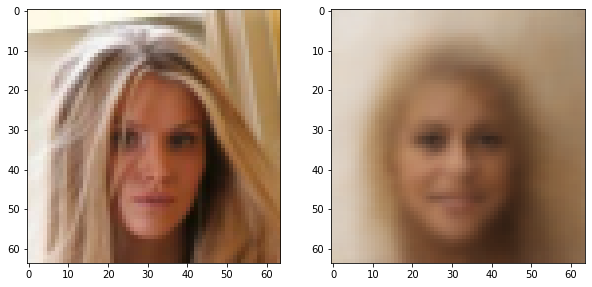

In [11]:
autoencoder = AE(train_loader.dataset[0][0].shape, device, 48, convolutive=True)
state = torch.load("./ae48conv64CelebA.model")
autoencoder.model.load_state_dict(state)
model = autoencoder.model.to(device)
# model.eval()

for x_val, _ in test_loader:
    fig,ax = plt.subplots(1,2,figsize=(10,10))

    ax[0].imshow(np.transpose(x_val[0], (1,2,0)))

    x_val = x_val.to(device)

    model.eval()
    yhat = model(x_val)
    ax[1].imshow(np.transpose(yhat[0].cpu().detach().numpy(), (1,2,0)))
    plt.show()
    break

In [12]:
gen_imgs = model(train_cpu[:1000].to(device)).detach().cpu()

gen_imgs = torch.transpose(gen_imgs, 1, 2)
gen_imgs = torch.transpose(gen_imgs, 2, 3)

real_cpu = torch.transpose(real_cpu, 1, 2)
real_cpu = torch.transpose(real_cpu, 2, 3)

evaluate_fid_score(real_cpu[:1000].detach().cpu().numpy(), gen_imgs[:1000].detach().cpu().numpy(), batch_size=25)

88.44996902159977

### Particle Scheme

In [14]:
def val_ae_particles(x, autoencoder, device, d=48):
    with torch.no_grad():
        autoencoder.eval()

        r,c = 5,5

        gen_imgs = model.decode(x).detach().cpu().reshape(-1,3,64,64)

        cpt = 0
        fig,ax = plt.subplots(r,c)
        for i in range(r):
            for j in range(c):
                ax[i,j].imshow(np.transpose(gen_imgs[cpt],(1,2,0)))
                ax[i,j].axis("off")
                cpt += 1
                
        fig.set_size_inches(6, 6)
        plt.tight_layout()
        plt.show()

In [15]:
def J(x):
    target = next(dataiter)[0].to(device)
    target_encoded = model.encode(target)
    
    sw = sliced_wasserstein(x, target_encoded, num_projections=1000, device=device, 
                           u_weights=None, v_weights=None, p=2) 
    return sw/2

In [16]:
rand_sampler = torch.utils.data.RandomSampler(train_dataset) #, replacement=True)
train_sampler = torch.utils.data.DataLoader(train_dataset, batch_size=500, sampler=rand_sampler)
dataiter = iter(cycle(train_sampler))

torch.Size([1000, 48])


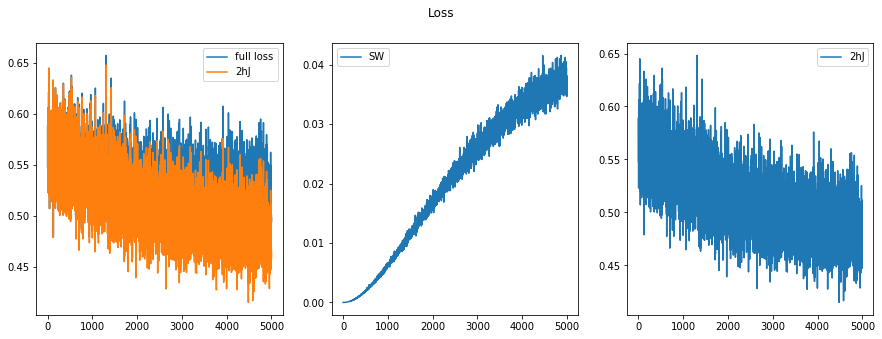

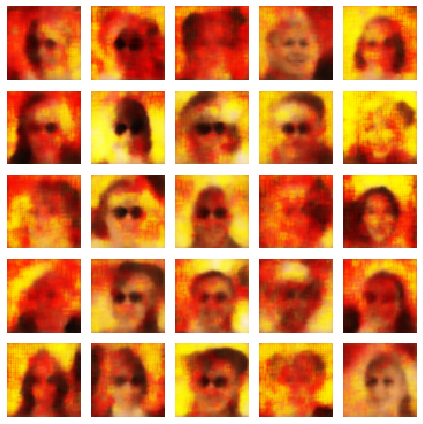

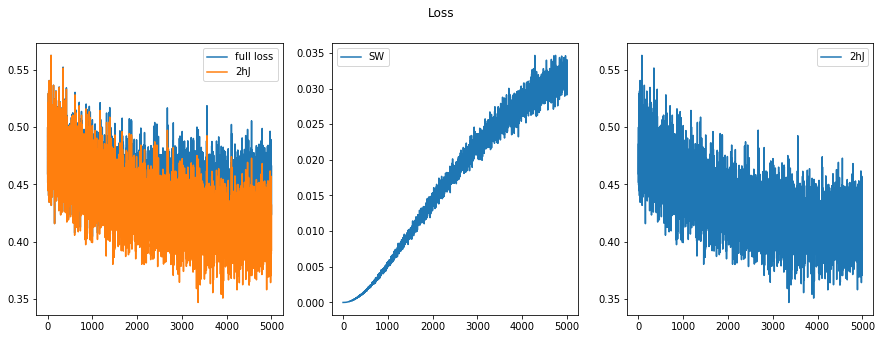

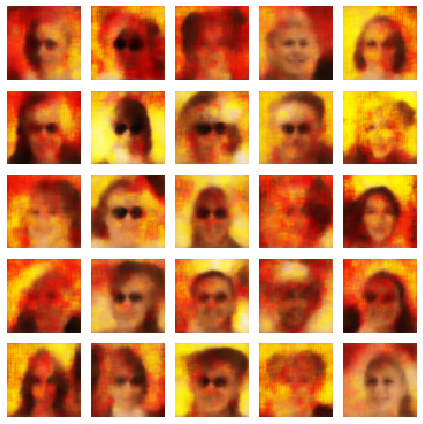

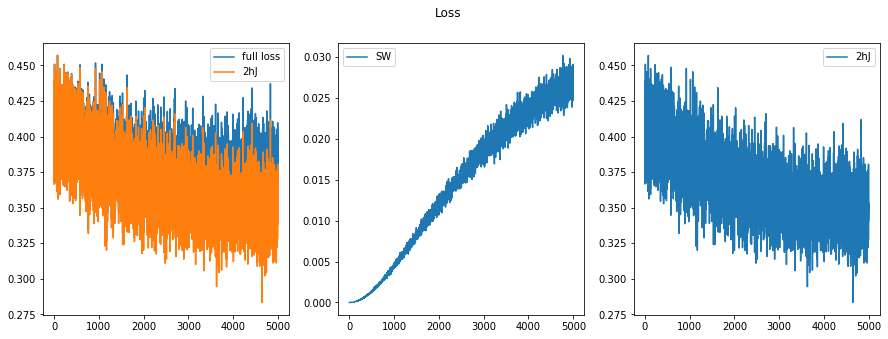

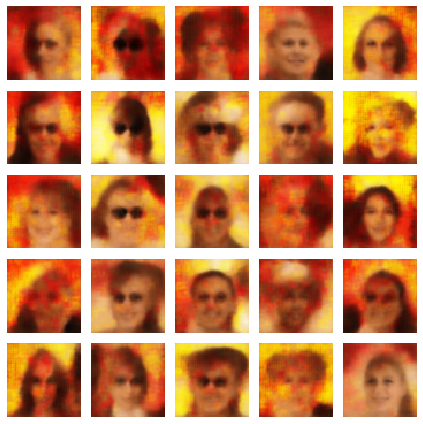

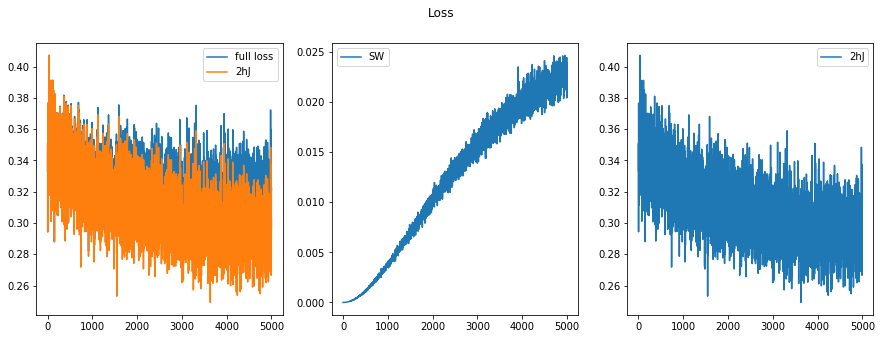

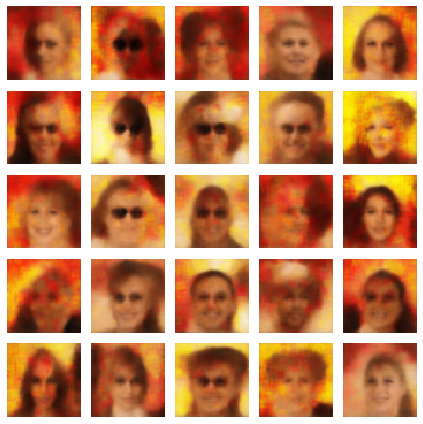

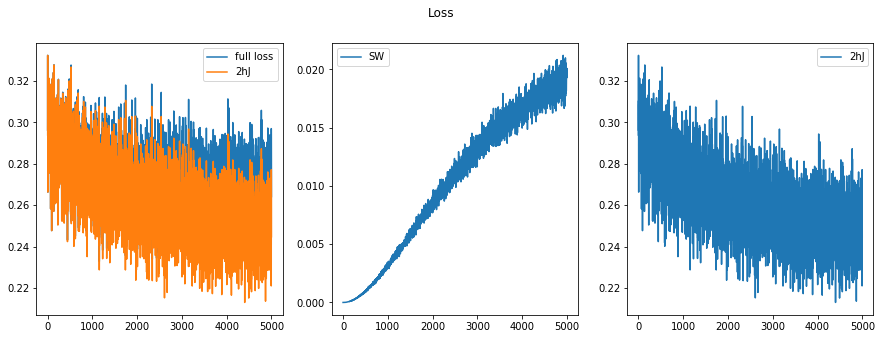

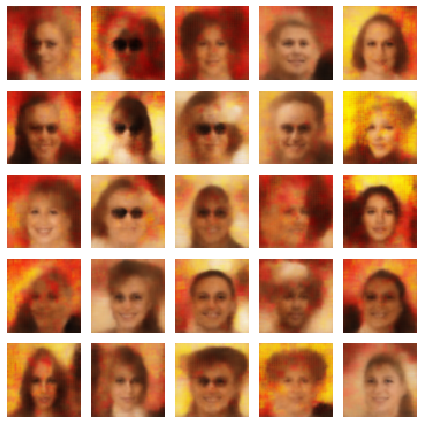

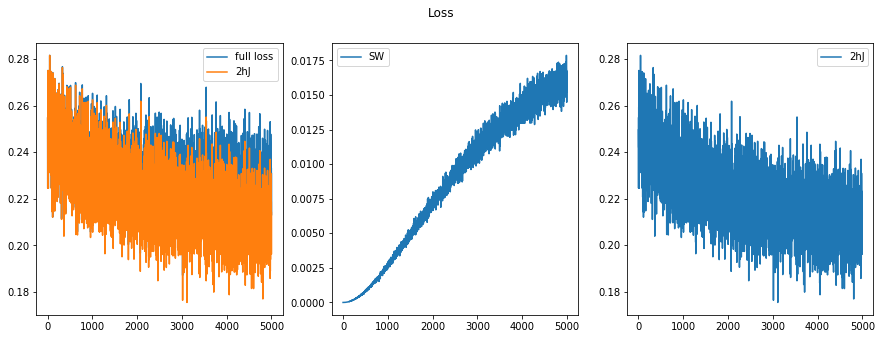

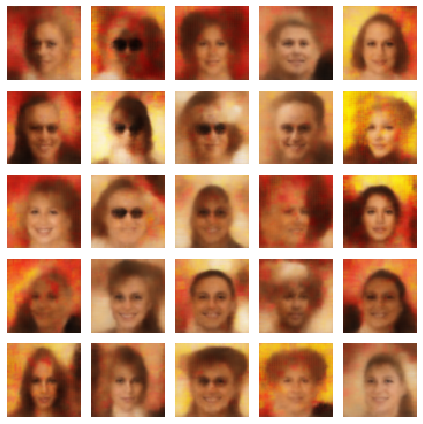

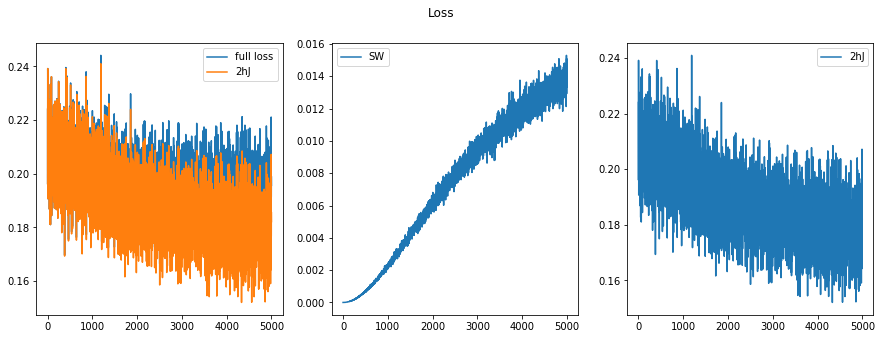

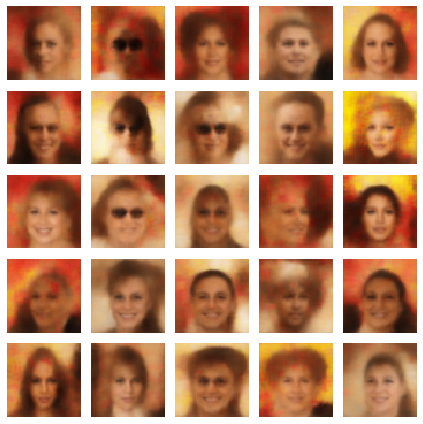

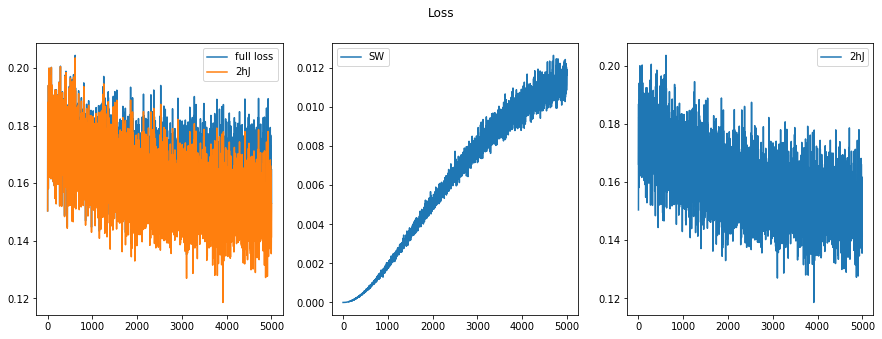

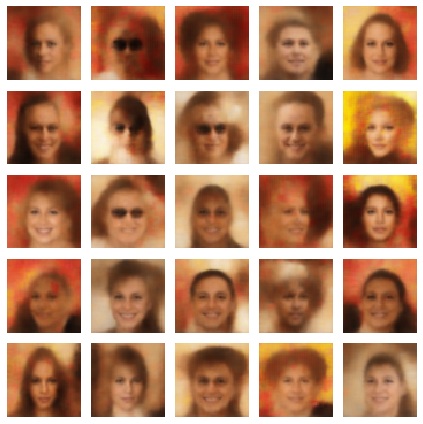

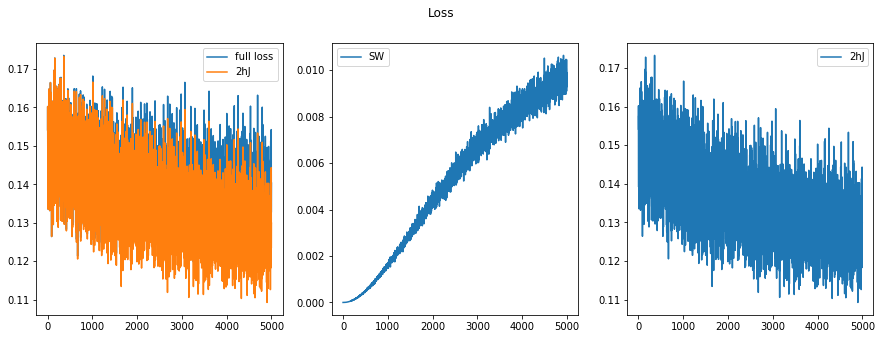

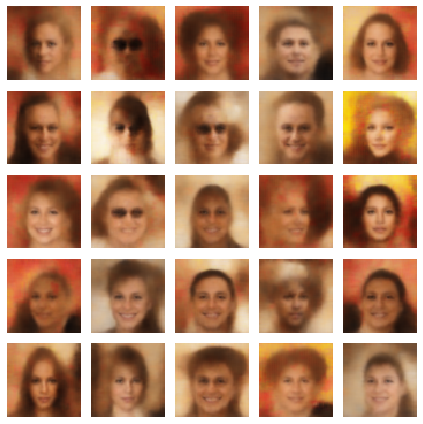

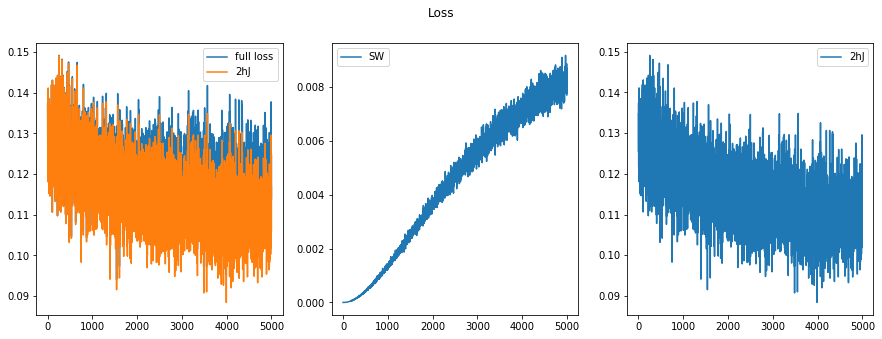

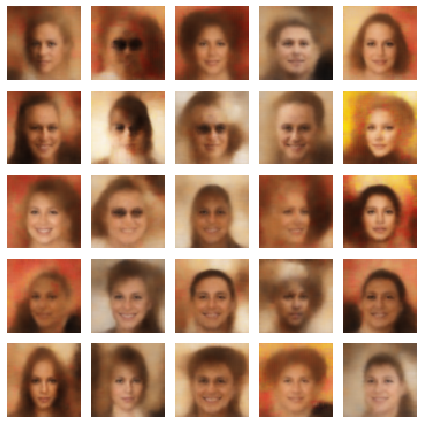

In [17]:
t_init = 0
t_end = 1
h = 0.1

n_steps = int(np.ceil((t_end-t_init)/h))

d = 48

n = 1000

x0 = torch.randn(n, d).to(device)

print(x0.shape)

n_epochs = 5000*np.ones(n_steps)
# n_epochs[0] = 5000
# n_epochs[1] = 2000
# n_epochs[2] = 1000

Lx = SWGF(x0, h, n_step=np.int(np.ceil((t_end-t_init)/h)), n_epochs=n_epochs.astype(int),
          J=J, emd1D=emd1D, sliced_wasserstein=sliced_wasserstein,
          lr=1, num_projections=1000, device=device, plot_train=True,
          plot=True)

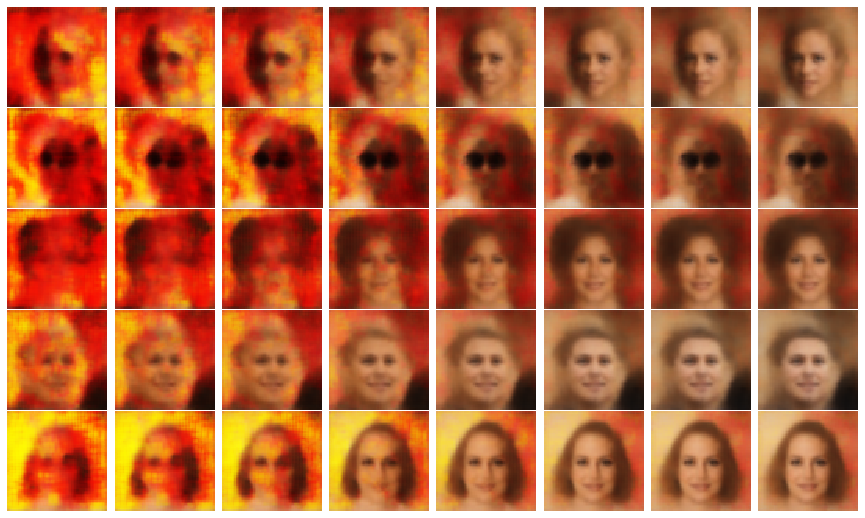

In [25]:
inds = [0,1,2,4,6,8,9,10]

r, c = 5, len(inds)

fig,ax = plt.subplots(r,c,figsize=(12,7))

for i in range(r):
    for j in range(len(inds)):
        gen_imgs = model.decode(Lx[inds[j]]).detach().cpu().reshape(-1,3,64,64)
        ax[i,j].imshow(np.transpose(gen_imgs[i],(1,2,0)))
        ax[i,j].axis("off")
        

plt.tight_layout(pad=0, h_pad=0.1, w_pad=0.005)
plt.show()

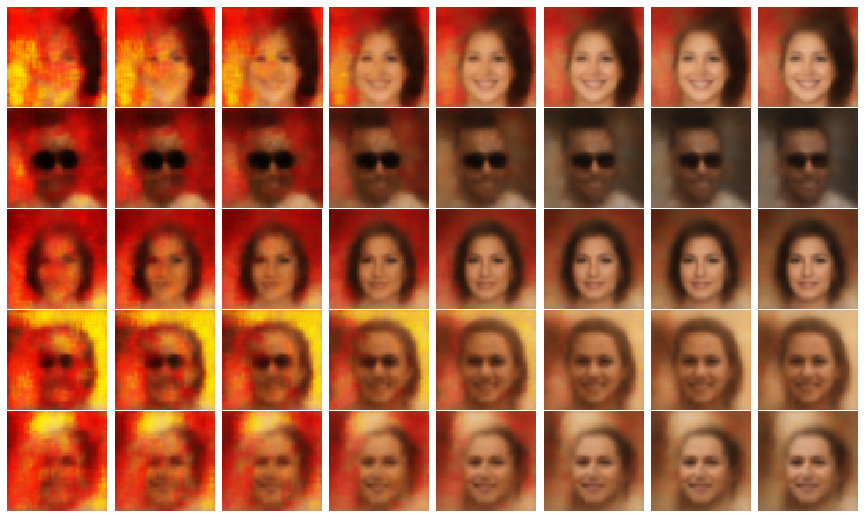

In [24]:
inds = [0,1,2,4,6,8,9,10]

r, c = 5, len(inds)

fig,ax = plt.subplots(r,c,figsize=(12,7))

for i in range(r):
    for j in range(len(inds)):
        gen_imgs = model.decode(Lx[inds[j]]).detach().cpu().reshape(-1,3,64,64)
        ax[i,j].imshow(np.transpose(gen_imgs[i+500],(1,2,0)))
        ax[i,j].axis("off")
        

plt.tight_layout(pad=0, h_pad=0.1, w_pad=0.005)
plt.show()

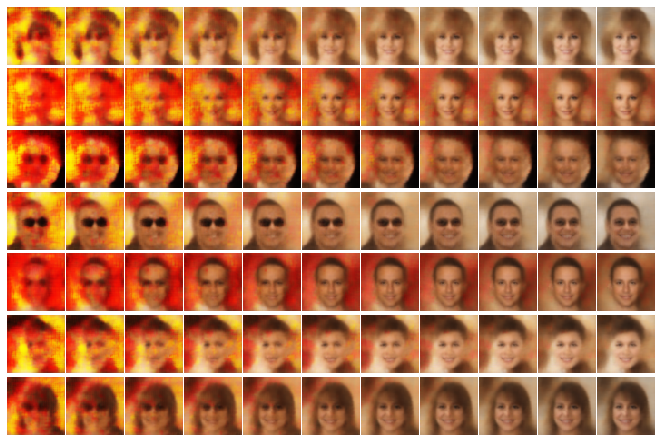

In [20]:
r, c = 7, len(Lx)

fig,ax = plt.subplots(r,c,figsize=(9,6))

for i in range(r):
    for j in range(len(Lx)):
        gen_imgs = model.decode(Lx[j]).detach().cpu().reshape(-1,3,64,64)
        ax[i,j].imshow(np.transpose(gen_imgs[i],(1,2,0)))
        ax[i,j].axis("off")
        
# fig.set_size_inches(6, 6)
# plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)

plt.tight_layout(pad=0, h_pad=0.1, w_pad=0.1)
plt.show()     